In [1]:
# !/usr/bin/env python3
# Use other Python kernel other than the in ADS integrated one
# to provide more flexibility in the code
# and to avoid the limitation of the ADS integrated Python kernel

''' File: data_pre_processing.ipynb:
    This file is used to modify the generated data from data_gen.ipynb to finally match the format required by further DNN training by PyTorch.
'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import h5py
import os

In [4]:
# Function Loading ...

def smooth_vec(y: np.ndarray) -> np.ndarray:
        '''use savgol_filter to smooth input vector'''
        n = y.size
        if n < 5:
            return y
        win = min(11, n if n % 2 == 1 else n - 1)
        win = max(win, 5)
        return savgol_filter(y, window_length=win, polyorder=2, mode='interp')


def error_gain_calc(meas_data_selected: np.ndarray, meas_data_smooth: np.ndarray):
    
    g1_matrix = np.matmul(meas_data_selected, meas_data_smooth.T)
    g2_matrix = np.matmul(meas_data_smooth, meas_data_smooth.T)
    g = np.sum(np.diag(g1_matrix)) / np.sum(np.diag(g2_matrix))
    error_gain = g - 1

    return error_gain, g


def alpha_beta_calc(Id_meas, Id_base, g,
                   n_bins=20, min_count=10,
                   log_bins=True, robust=False):

    Id_meas = np.asarray(Id_meas, float)
    Id_base = np.asarray(Id_base, float)
    if Id_meas.shape != Id_base.shape:
        raise ValueError("Id_meas 与 Id_base 形状必须一致")

    # 1) 残差与参考横轴
    ref = np.abs(g * Id_base).ravel()
    r   = (Id_meas - g * Id_base).ravel()

    good = np.isfinite(ref) & np.isfinite(r)
    ref = ref[good]; r = r[good]
    if ref.size < 2:
        raise ValueError("有效样本太少，无法拟合")

    # 2) 生成分箱（优先对数分箱；动态范围不足则退化为线性分箱）
    eps = 1e-15
    use_log = False
    if log_bins:
        pos = ref[ref > 0]
        if pos.size >= 10:
            lo, hi = np.percentile(pos, 5), np.percentile(pos, 95)
            if hi / max(lo, eps) >= 10:   # 至少一阶量级
                use_log = True
                lo = max(lo, eps)
                edges = np.logspace(np.log10(lo), np.log10(hi), n_bins + 1)
    if not use_log:
        lo, hi = np.percentile(ref, 5), np.percentile(ref, 95)
        edges = np.linspace(lo, hi, n_bins + 1)

    idx = np.digitize(ref, edges, right=False)  # 1..n_bins

    # 3) 每个箱的 σ（std 或 MAD）
    centers, sigmas, counts = [], [], []
    for b in range(1, len(edges)):
        m = (idx == b)
        c = int(np.count_nonzero(m))
        if c < min_count:
            continue
        center = np.median(ref[m])
        vals   = r[m]
        if robust:
            med = np.median(vals)
            sigma = 1.4826 * np.median(np.abs(vals - med))  # MAD→std
        else:
            sigma = vals.std(ddof=1)
        if np.isfinite(sigma) and sigma > 0:
            centers.append(center); sigmas.append(sigma); counts.append(c)

    centers = np.asarray(centers); sigmas = np.asarray(sigmas); counts = np.asarray(counts)
    if centers.size < 2:
        raise ValueError("有效分箱不足，调小 min_count 或增大 n_bins")

    # 4) 加权最小二乘拟合: sigma ≈ alpha * I + beta
    A = np.column_stack([centers, np.ones_like(centers)])
    w = np.sqrt(counts)                         # 权重≈置信度
    Aw = A * w[:, None]
    yw = sigmas * w
    (alpha, beta), *_ = np.linalg.lstsq(Aw, yw, rcond=None)

    # R^2 诊断
    yhat   = A @ np.array([alpha, beta])
    ss_res = float(np.sum((sigmas - yhat)**2))
    ss_tot = float(np.sum((sigmas - sigmas.mean())**2))
    r2     = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    diag = {
        "R2": r2,
        "centers": centers,
        "sigmas": sigmas,
        "counts": counts,
        "edges": edges,
        "used_log_bins": use_log,
    }
    return alpha, beta, diag



def noise_coefficient_estimation(meas_file: str, X_shape: dict, rename: list=None, plot_flag: bool=True, save_name: str=None):
    '''
    Read meas data from .csv and return numpy, 
    also maps range into Vds in [-3.5, 8.5],
    with step size of 0.1,
    estimate 3 paramters in order to generate noise on simulated data
    '''

    # >> read data from measurement file
    df = pd.read_csv(meas_file)
    if rename is None:
        row_name = df.columns[0]
        col_name = df.columns[1]
        value_name = df.columns[2]
    else:
        [row_name, col_name, value_name] = rename
        df = df.rename(columns={df.columns[0]: row_name, df.columns[1]: col_name, df.columns[2]: value_name})
    print(f'【CHECK】in current meas-data file:')
    print(f'\t row name is {row_name}, col name is {col_name}, value name is {value_name}')


    # >> validate dataset
    row_unique_value = df[row_name].unique()
    row_shape_meas_data = set()
    for index,value in enumerate(row_unique_value):
        row_shape_meas_data.add(df[df[row_name] == value].shape)
    if len(row_shape_meas_data) != 1:
        print(f'different sizes in each row detected: {row_shape_meas_data}')
    else:
        print(f'same size in each row detected: {len(row_unique_value)}*{row_shape_meas_data}')
    if (len(row_unique_value)) != X_shape['row_num'] :
        raise ValueError(f'The number of different rows is given {X_shape['row_num']} but is actually {len(row_unique_value)} with {row_unique_value.tolist()}')


    # >> transform data to numpy and reshape + range mapping
    meas_data_selected = np.zeros((X_shape['row_num'], X_shape['col_num']), dtype=np.float64)
    meas_data_smooth = meas_data_selected.copy()
    meas_data_save = np.zeros((1, X_shape['row_num'], X_shape['col_num']), dtype=np.float64)
    row_unique_value.tolist().sort(reverse=False)
    for index, row_value in enumerate(row_unique_value):
        new_col_range = np.linspace(min(X_shape['col_range']), max(X_shape['col_range']), X_shape['col_num'])
        old_col_range = df[df[row_name] == row_value][col_name].to_numpy()
        old_value_range = df[df[row_name] == row_value][value_name].to_numpy()
        meas_data_selected[index,:] = np.interp(new_col_range, old_col_range, old_value_range)
        meas_data_smooth[index,:] = smooth_vec(meas_data_selected[index,:])


    # >> params regression - least squares scaling
    error_gain, g, alpha, beta = None, None, None, None

    # calculate error_gain
    error_gain, g = error_gain_calc(meas_data_selected, meas_data_smooth)

    # calculate alpha, beta
    meas_data_error = meas_data_selected - (g * meas_data_smooth)
    std_vector = np.sqrt(np.diag(np.matmul(meas_data_error.T, meas_data_error))/X_shape['row_num'])

    # alpha, beta = np.polyfit(new_col_range, std_vector, deg=1)

    alpha, beta, dialog = alpha_beta_calc( Id_meas=meas_data_selected,
                                        Id_base=meas_data_smooth,
                                        g = g ) # TODO: solve this part

    # optional, save measurement data with ruled format
    if save_name:
        # meas_data_save = meas_data_selected.copy()
        meas_data_save[0,:,:] = meas_data_smooth.copy()

        # check if dir exist
        split_index = meas_file[::-1].find('/')
        path = meas_file[:(- split_index)] + save_name

        with h5py.File(path, 'w') as f:
            f.create_dataset('X', data=meas_data_save)
            print(f'sucessfully save measurement data under path {path}, with shape of {meas_data_selected.shape}')
        

    # optional, plot to check performance
    if plot_flag:

         # test plot 1 - original data vs imterploted data vs smoothed data
        _, ax = plt.subplots(2,2, figsize=(18, 13))
        for index, row_value in enumerate(row_unique_value):
            range1 = df[row_name] == row_value
            range2 = df[col_name] >= X_shape['col_range'][0]
            range3 = df[col_name] <= X_shape['col_range'][1]
            range = range1 & range2 & range3
            # plot only within defined given col range
            ax[0,0].plot(df[range][col_name], df[range][value_name], label = f"{row_name} = {row_value} V")
            ax[0,1].plot(new_col_range, meas_data_selected[index,:], label = f"{row_name} = {row_value} V")
            ax[1,0].plot(new_col_range, smooth_vec(meas_data_selected[index,:]), label = f"{row_name} = {row_value} V")
            # ax[1,1].plot(new_col_range, meas_data_selected[index,:] - smooth_vec(meas_data_selected[index,:]), label = f"{row_name} = {row_value} V")
            ax[1,1].plot(df[range][col_name], df[range][value_name], label = f"{row_name} = {row_value} V", linestyle = '--')
            ax[1,1].plot(new_col_range, smooth_vec(meas_data_selected[index,:]), label = f"{row_name} = {row_value} V")

        ax[0,0].set_title('test plot of original meas data')
        ax[0,1].set_title('test plot of interplotted data')
        ax[1,0].set_title('test plot of smoothed data')
        # ax[1,1].set_title('error between interplotted adn sommthed data')
        ax[1,1].set_title('smoothed v.s. original data')
        for i, j in np.ndindex((2,2)):
            ax[i,j].set_xlabel(f"{col_name}")
            ax[i,j].set_ylabel(f"{value_name}")
            ax[i,j].legend()
            ax[i,j].grid()
        plt.show()

        # test plot 2 - regression of alpha and beta
        _, ax = plt.subplots(figsize=(9, 6.5))
        ax.plot(new_col_range, std_vector, 'x', label = 'std of errors')
        ax.plot(new_col_range, new_col_range * alpha + beta,'--', label='regression curve')
        ax.set_title('test plot of original meas data')
        ax.set_xlabel(f"{col_name}")
        ax.set_ylabel(f"Standard Deviation of {value_name}")
        ax.legend()
        ax.grid()
         
    return error_gain, g, alpha, beta


# filter rule 1: max value of each sample shoudl be at least > x, to remove meaningless noise
# filter rule 2: with risen Vds, max Ids must also rise
def filter_mask(X: np.ndarray, mask_1_flag = False, mask_2_flag = False, threshold:float = 2) -> np.ndarray:

    X = np.asarray(X)
    mask_2 = np.array([True]*X.shape[0]).reshape(-1,1)  # default all True
    mask_1 = mask_2.copy()
    # assert X.ndim == 3 and X.shape[1] == 7 and X.shape[2] == 121
    #  -> (N, 7)
    last_col = X[:, :, -1]

    if mask_1_flag:
        max_per_sample = last_col.max(axis=1, keepdims=True).reshape(-1,1)
        mask_1 = (max_per_sample > threshold) # for output > 2, transfer > 0.05

    if mask_2_flag:
        diffs = np.diff(last_col, axis=1) # attention here, data in each sample is of ascending order
        mask_2 = np.all(diffs > 0, axis=1).reshape(-1,1)

    mask = mask_1 & mask_2

    return mask

# filter rule 1: max value of each sample shoudl be at least > x, to remove meaningless noise
# filter rule 2: with risen Vds, max Ids must also rise (soft version: allow small / few violations)
def soft_filter_mask(X: np.ndarray, 
                     mask_1_flag: bool = False, mask_2_flag: bool = False, 
                     threshold: float = 2.0, eps_small: float = 1e-2) -> np.ndarray:

    X = np.asarray(X)
    N = X.shape[0]

    # default: keep all
    mask_1 = np.ones((N, 1), dtype=bool)
    mask_2 = np.ones((N, 1), dtype=bool)
    last_col = X[:, :, -1]

    # --------- filter1: global max threshold ----------
    if mask_1_flag:
        max_per_sample = last_col.max(axis=1, keepdims=True)  # (N, 1)
        mask_1 = (max_per_sample > threshold)                 # (N, 1)

    # --------- filter2: soft monotonicity on last_col vs. row index ----------
    if mask_2_flag:
        diffs = np.diff(last_col, axis=1)   # shape: (N, n_rows-1)

        # Tolerate extremely small numerical fluctuations: 
        # Only consider "significant decreases" as violations of monotonicity
        # eps_small: Numerical fluctuation threshold; ignore values ​​less than eps_small.

        bad_steps = diffs <= (-1)*eps_small        # (N, n_rows-1) bool
        num_steps = diffs.shape[1]
        num_bad = bad_steps.sum(axis=1)       
        frac_bad = num_bad / max(1, num_steps)

        # The magnitude of the decline (only looking at the points of decline)
        drop_mag = np.where(bad_steps, -diffs, 0.0)   # A decrease is positive, otherwise it is 0.
        max_drop_abs = drop_mag.max(axis=1)           # Maximum decrease for each sample

        # Relative magnitude (relative to the maximum Ids of this sample)
        per_sample_max = last_col.max(axis=1)
        max_drop_rel = max_drop_abs / np.clip(per_sample_max, 1e-6, None)

        # ---- Soft Rule: Allows small and minor decreases ----
        # 1) A maximum of 10% of the step size is allowed to be a "significant decrease".
        max_frac_bad = 0.10
        # 2) The maximum allowable drop is a peak value of <= 10% (equivalent to a small local fluctuation).
        max_rel_drop = 0.10

        good = (frac_bad <= max_frac_bad) & (max_drop_rel <= max_rel_drop)
        mask_2 = good.reshape(-1, 1)

    mask = mask_1 & mask_2
    return mask

In [5]:
'''STEP 1 : Variable INIT'''

# ---------------------------------PATH-------------------------

# path of saved .h5 data
# generated data path, the data adding noise will be saved in sub folder
data_save_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data/log_bigger_dataset/dataset_symmetric_14param/dataGen_mp_1"
noisy_data_path = data_save_path + '/noisy_data'

# path of measured data
meas_data_path = r"E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/ref_data"
meas_file_name = "meas_data_Unidi_Output.csv"
meas_file = meas_data_path + '/' + meas_file_name

meas_corrected_data_name = 'meas_smoothed_Uni_Output.h5'
# ----------------------------------VAR-------------------------
num_set = 15 # here only 10 process/dataset available
num_samples_single_set = 30000 # in each process/dataset 100 samples/simulations available

row_X = 7
col_X = 121
row_Y = 14
col_Y = 1
row_range = (1, 7)
col_range = (-3.5,8.5)
goal_name = 'X_iv'  # 'X_iv' or 'X_gm'


X_shape = {
    "row_num": row_X,
    "col_num": col_X,
    "row_range": row_range,
    "col_range": col_range
}
Y_shape = {
    "row_num": row_Y,
    "col_num": col_Y
}
rename_meas = ['Vds', 'Vgs', 'Ids'] if goal_name == 'X_gm' else ['Vgs', 'Vds', 'Ids']   # or None: keep original name


【CHECK】in current meas-data file:
	 row name is Vgs, col name is Vds, value name is Ids
same size in each row detected: 7*{(501, 3)}
sucessfully save measurement data under path E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/ref_data/meas_smoothed_Uni_Output.h5, with shape of (7, 121)


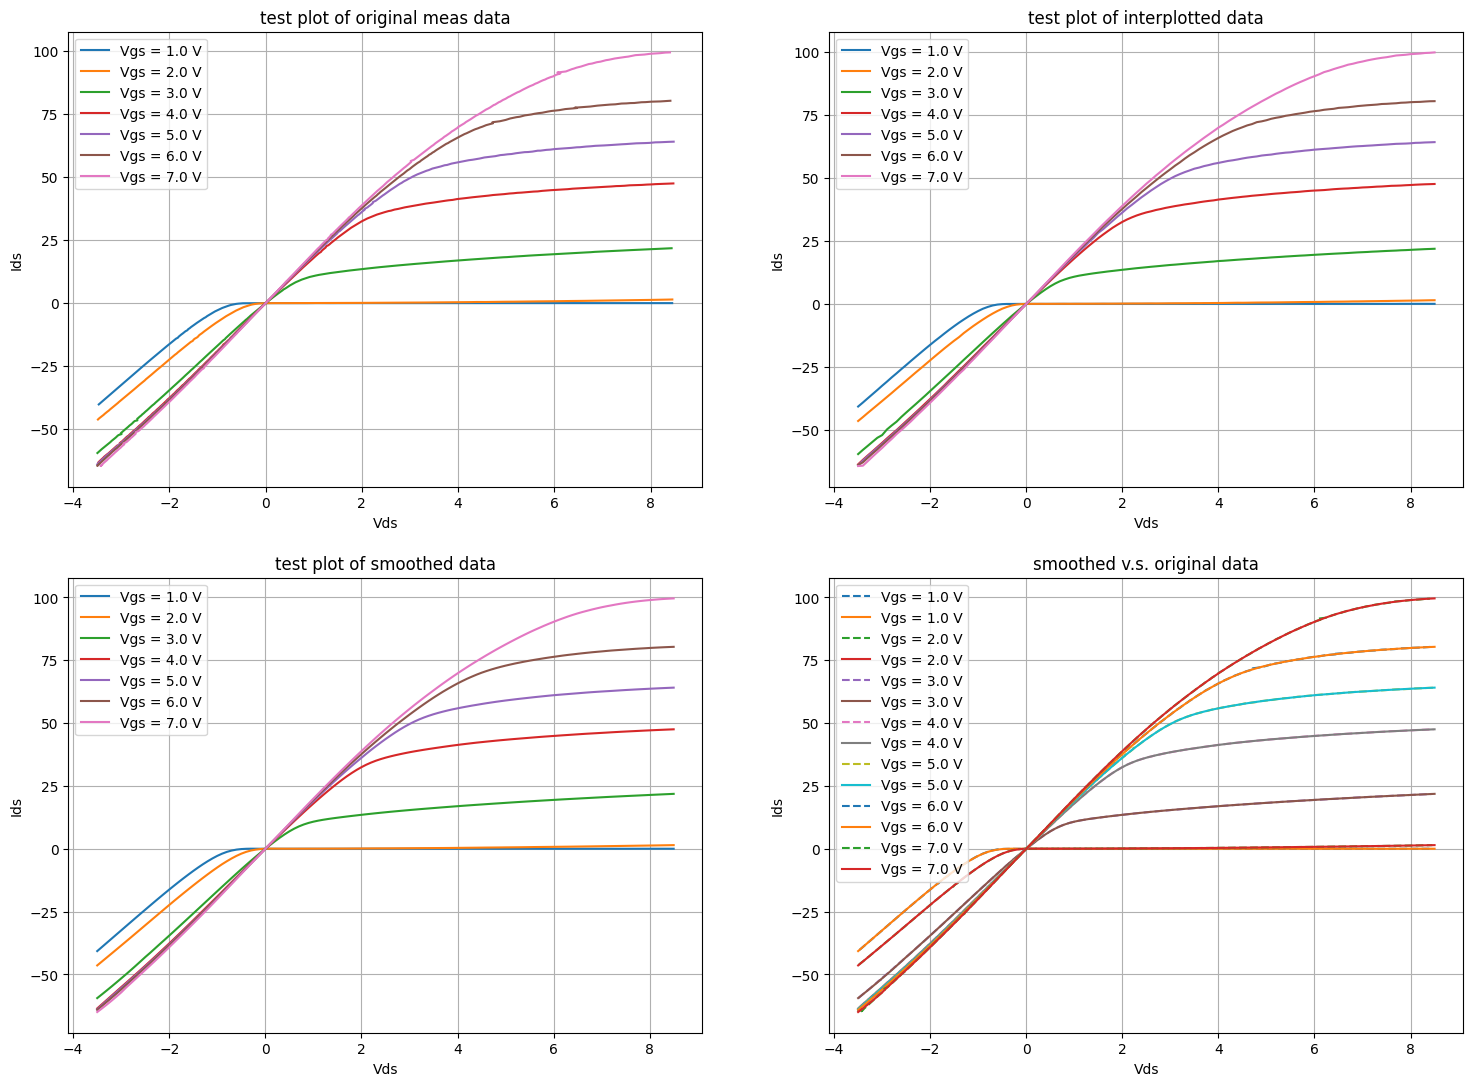

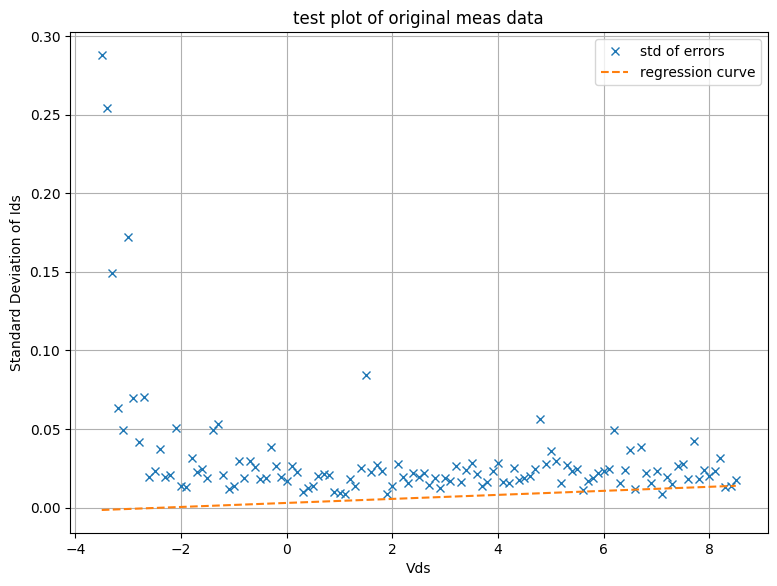

In [6]:
'''STEP 2 : calculate Noise Coefficient'''

plot_validation_flag = True
validation_data_save_name = meas_corrected_data_name

error_gain, g, alpha, beta = noise_coefficient_estimation(meas_file, X_shape, rename_meas, plot_validation_flag, validation_data_save_name)



In [7]:
'''STEP 3 : add noice in simulation data'''

# pre-define matrixs
X_goal = np.zeros((num_set*num_samples_single_set, X_shape['row_num'], X_shape['col_num']),dtype=np.float64)
Y = np.zeros((num_set*num_samples_single_set, Y_shape['row_num'], Y_shape['col_num']),dtype=np.float64)

# trans data from .h5 to numpy
cur_index = 0
for process_id in range(1, num_set + 1):
    with h5py.File(f"{data_save_path}\\dataset_process_{process_id}.h5", 'r') as f:
        index_update = f[goal_name].shape[0]
        X_goal[cur_index : cur_index + index_update, :, :] = f[goal_name]
        Y[cur_index : cur_index + index_update, :, :] = f['Y']
        cur_index += index_update

# remove unfilled part
X_goal = X_goal[:cur_index]
Y = Y[:cur_index]

# generated data is in descending order of row, need to be reversed
X_goal = X_goal[:,::-1,:] 

# add noise in simulation I-V data
sigma_matrix = np.abs(alpha * X_goal + beta)
noise = np.random.default_rng().normal(loc=0.0, scale=sigma_matrix)
X_goal_noisy = g * X_goal + noise
# X_goal_noisy = X_goal

# remove outliers
# filter rule 1: max value of each sample shoudl be at least > x, to remove meaningless noise
# filter rule 2: with risen Vds, max Ids must also rise
rule_1_flag = True
rule_2_flag = False

# normal filter
outliner_mask = filter_mask(X_goal_noisy, rule_1_flag, rule_2_flag, threshold = 10.0)
# soft filter
# outliner_mask = soft_filter_mask(X_goal_noisy, rule_1_flag, rule_2_flag, threshold = 100.0)

X_goal_noisy_outlier_removal = X_goal_noisy[outliner_mask.reshape(-1),:,:]
Y_outlier_removal = Y[outliner_mask.reshape(-1),:,:]


In [ ]:
'''STEP x : Gen 2-stage dataset'''

dataset_1 = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_gen/data/bigger_dataset/noisy_data/train_bigger_dataset_filter_7row.h5"
dataset_2 = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_gen/data/normal_dataset/noisy_data/train_dataset_7row.h5"
dataset_3 = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_gen/data/log_normal_dataset/noisy_data/train_log_dataset_7row_2.h5"
dataset_4 = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_gen/data/log_normal_dataset/noisy_data/train_log_dataset_7row_1.h5"


f1 = h5py.File(dataset_1, 'r')
f2 = h5py.File(dataset_2, 'r')
f3 = h5py.File(dataset_3, 'r')
f4 = h5py.File(dataset_4, 'r')

print('f1-x shape: ',f1['X'].shape)
print('f2-x shape: ',f2['X'].shape)
print('f3-x shape: ',f3['X'].shape)
print('f4-x shape: ',f4['X'].shape)
print('f-x type: ',type(f3['X']))

f_X = np.vstack((f1['X'],f2['X'],f3['X']))
f_Y = np.vstack((f1['Y'],f2['Y'],f3['Y']))

meas_like_X = f4['X']
meas_like_Y = f4['Y']

print('f_X shape: ',f_X.shape)
print('f_Y shape: ',f_Y.shape)

print('meas_like_X shape: ',meas_like_X.shape)
print('meas_like_Y shape: ',meas_like_Y.shape)

In [ ]:
rule_1_flag = True
rule_2_flag = True
outliner_mask = filter_mask(f_X, rule_1_flag, rule_2_flag)
meas_like_outliner_mask = filter_mask(meas_like_X, rule_1_flag, rule_2_flag)

train_X = f_X[outliner_mask.reshape(-1),:,:]
train_Y = f_Y[outliner_mask.reshape(-1),:,:]

meas_like_X = meas_like_X[meas_like_outliner_mask.reshape(-1),:,:]
meas_like_Y = meas_like_Y[meas_like_outliner_mask.reshape(-1),:,:]

print('shape of full training set X: ',train_X.shape)
print('shape of full training set Y: ',train_Y.shape)

print('shape of meas like fine-turning set X: ',meas_like_X.shape)
print('shape of meas like fine-turning set Y: ',meas_like_Y.shape)


In [ ]:
full_data_save_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/dataset/training/stage_1_full_data.h5"
meas_like_data_save_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/dataset/training/stage_2_ml_data.h5"
full_plus_ml_data_save_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/NN_training/dataset/training/stage_1_fpml_data.h5"

with h5py.File(full_data_save_path, 'w') as f:
    f.create_dataset('X', data=train_X)
    f.create_dataset('Y', data=train_Y)

with h5py.File(meas_like_data_save_path, 'w') as f:
    f.create_dataset('X', data=meas_like_X)
    f.create_dataset('Y', data=meas_like_Y)

with h5py.File(full_plus_ml_data_save_path, 'w') as f:
    f.create_dataset('X', data=np.vstack((train_X, meas_like_X)))
    f.create_dataset('Y', data=np.vstack((train_Y, meas_like_Y)))

f1.close()
f2.close()
f3.close()
f4.close()

In [8]:
print(X_goal_noisy.shape)
print(Y.shape)


print(X_goal_noisy.shape, X_goal_noisy_outlier_removal.shape)
print(Y.shape, Y_outlier_removal.shape)
# print(np.where(outliner_mask==False)[0])
print(np.where(outliner_mask==False)[0].shape)


(431400, 7, 121)
(431400, 14, 1)
(431400, 7, 121) (180497, 7, 121)
(431400, 14, 1) (180497, 14, 1)
(250903,)


In [9]:
'''STEP 4 : save noisy data as torch'''

# check if dir exist
if not os.path.exists(noisy_data_path):
    os.makedirs(noisy_data_path)
    print('dir not found, create new dir based on given path')
else:
    ('path exists')
print('saving data ...')

file_name = 'Uni_Output_log_mask1.h5'
path = noisy_data_path + '/' + file_name
with h5py.File(path, 'w') as f:
    f.create_dataset('X', data=X_goal_noisy_outlier_removal)
    f.create_dataset('Y', data=Y_outlier_removal)


print('data saved !')

dir not found, create new dir based on given path
saving data ...
data saved !


In [ ]:
# test :: build a classifier to findout the data matching the distribution of meas data
# remove outliers
max_per_sample = np.max(X_iv_noisy_outlier_removal, axis=(1,2)).reshape(-1,1)
ratio_vector = np.zeros((max_per_sample.shape[0],1),dtype=np.float64)
for index in range(max_per_sample.shape[0]):
    ratio_vector[index] = np.mean(np.diff(X_iv_noisy_outlier_removal[index, :, -1],axis = 0)) / (max_per_sample[index, 0] / 6)

positive_ratio_index = ratio_vector > 0

print(f'ratio is {ratio_vector}')
print(f'positive ratio index is {np.where(positive_ratio_index==True)[0]}', f'with size of {np.where(positive_ratio_index==True)[0].shape}')
print(np.max(ratio_vector), np.where(ratio_vector==np.max(ratio_vector))[0])




In [ ]:
# test :: merge multiple different .h5 datasets

file_name_1 = 'E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\data\\log_bigger_dataset\\dataset_symmetric_NS0\\dataGen_mp_1\\noisy_data\\Uni_Output_log_mask1.h5'

file_name_2 = 'E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\data\\log_bigger_dataset\\dataset_symmetric_NS0\\dataGen_mp_2\\noisy_data\\Uni_Output_log_mask1.h5'

# file_name_3 = 'E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\data\\log_Bidi_dataset\\dataGen3\\noisy_data\\Bidi_Transfer_log.h5'

save_path = 'E:\\personal_Data\\Document of School\\Uni Stuttgart\\Masterarbeit\\Code\\param_regression\\ADS_Parameter_Fitting\\IV_param_regression\\data\\log_bigger_dataset\\dataset_symmetric_NS0\\data_merge'

merge_file_name = 'Uni_Output_merge_mask1.h5'

f1 = h5py.File(file_name_1, 'r')
f2 = h5py.File(file_name_2, 'r')
# f3 = h5py.File(file_name_3, 'r')

# match size
f_iterator = [f1,f2]
f_col = set(i['X'].shape[2] for i in f_iterator)
for index,f in enumerate(f_iterator):
    print(f"before correction: f{index+1}['X'].shape = {f['X'].shape}, f{index+1}['Y'].shape = {f['Y'].shape}")

# merge data

if len(f_col) != 1:
    print(f'[Error] col-num not matched !!!')
else:
    data_x = np.array(f_iterator[0]['X'])
    data_y = np.array(f_iterator[0]['Y'])
    for i in range(1,len(f_iterator)):
        data_x = np.vstack((data_x, f_iterator[i]['X']))
        data_y = np.vstack((data_y, f_iterator[i]['Y']))

print(f"after correction: data['X'].shape = {data_x.shape}, data['Y'].shape = {data_y.shape}")

# save data
path = save_path + '/' + merge_file_name
with h5py.File(path, 'w') as f:
    f.create_dataset('X', data=data_x)
    f.create_dataset('Y', data=data_y)

print('data saved !')
for f in f_iterator:
    f.close()

In [ ]:
meas_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/data/meas_file_reshape_7row.h5"
save_path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data_pre_processing/data/temp.h5"

f = h5py.File(meas_path, 'r')
print(f.keys())
print(f['X'])

temp = np.array(f['X'][:]).reshape(1,7,121)
print(temp.shape)
f.close()

with h5py.File(save_path, 'w') as f:
    f.create_dataset('X', data=temp)
    print(f.keys())
    print(f['X'].shape)

In [ ]:
# test plot

index = 233
index -= 1


path = "E:/personal_Data/Document of School/Uni Stuttgart/Masterarbeit/Code/param_regression/ADS_Parameter_Fitting/IV_param_regression/data/log_Bidi_dataset/dataGen1/noisy_data/Bidi_Transfer_clean_log.h5"

fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
with h5py.File(path, 'r') as f:
    x_axis = np.linspace(min(X_shape['col_range']), max(X_shape['col_range']), f['X'].shape[2])
    row_list = np.linspace(min(X_shape['row_range']), max(X_shape['row_range']), f['X'].shape[1])
    for i in range(f['X'].shape[1]):
        ax.plot(x_axis, f['X'][index, i, :], label=f'V_row = {row_list[i]}')
        ax.grid(True)
        ax.set_title('noisy I-V')
        ax.set_xlabel("V_col")
        ax.set_ylabel("Ids")
        ax.legend()


    